In [17]:
# Install these requirements if not already installed
using FileIO, Images, JLD, Statistics

# Loading images

This section shows how to load a large batch of images in two ways - sequentially and parallely in threads.

You only need to do this once, the images are saved in a JLD file at the end. (Skip to [the next section](#Load-and-process-inputs) if done already)

In [2]:
TRAIN_IMAGES_DIR = "train/"
TEST_IMAGES_DIR = "test/"

"test/"

In [3]:
function images_in_dir(DIR::String)
    images = String[]
    for file in readdir(DIR)
        if endswith(file, ".jpg")
            push!(images, joinpath(DIR, file))
        end
    end
    return images
end

images_in_dir (generic function with 1 method)

In [4]:
function load_image(path::String)
    img = load(path)
    arr = channelview(img)
    return (permuteddimsview(arr, [2, 3, 1]))
end

load_image (generic function with 1 method)

In [5]:
train_images = images_in_dir(TRAIN_IMAGES_DIR)
test_images = images_in_dir(TEST_IMAGES_DIR)

4000-element Array{String,1}:
 "test/000940378805c44108d287872b2f04ce.jpg"
 "test/0017242f54ececa4512b4d7937d1e21e.jpg"
 "test/001ee6d8564003107853118ab87df407.jpg"
 "test/002e175c3c1e060769475f52182583d0.jpg"
 "test/0036e44a7e8f7218e9bc7bf8137e4943.jpg"
 "test/0038ed6f7417b8275b393307f66cb1e3.jpg"
 "test/0059dfa41de4441fc23b9a4b98ba99cb.jpg"
 "test/0061bd302d735db829418cb90b4e6040.jpg"
 "test/00754573d8c7223e73da553dd43780bd.jpg"
 "test/008d9fce71c8e03a4c9cdd15ea908573.jpg"
 "test/00a36d4d6d152404670276fc983273bc.jpg"
 "test/00b706122b87e0fa275ff59e39d4d94b.jpg"
 "test/00c054da839d5518e59790f7d867f317.jpg"
 ⋮                                          
 "test/ff680e4f9bb7283eaf4cbc7530099657.jpg"
 "test/ff6d1ceccb9e19e750fc7e2c637c3c83.jpg"
 "test/ff6f8ae36c1d66214127fe5008789407.jpg"
 "test/ff7403812efdc9ec93301c32e8f39c30.jpg"
 "test/ff8bc1e0fe61fba8ea9a05c91cd0933a.jpg"
 "test/ff9937f41664d329822e72c6a14d3f16.jpg"
 "test/ff9c0bafab5f89febd18c1d6865c079b.jpg"
 "test/ffaafd0c9f2f0e7317

In [6]:
function load_all_images(paths_vector)
    images_vector = Array{Float32}(undef, 32, 32, 3, 0)
    i = 0
    for image_file in paths_vector
        images_vector = cat(images_vector, load_image(image_file), dims=4)
        i += 1
        if i%100==0
            println(string("Processing image no. ", i, " in thread ", Threads.threadid()))
        end
    end
    return images_vector
end

load_all_images (generic function with 1 method)

In [7]:
function load_images_parallel(paths_vector, num_bins)
    len = length(paths_vector) # Number of images
    bin_size = floor(UInt, len/num_bins) # Size of each bin
    all_bins = Vector{String}[] # To store image filenames in each bin
    # Create bins of images filenames
    for bin=1:num_bins-1
        paths_bin = paths_vector[(bin-1)*bin_size+1 : bin*bin_size]
        push!(all_bins, paths_bin)
    end
    # Add last bin with all extra images
    push!(all_bins, paths_vector[(num_bins-1)*bin_size+1 : len])
    bins = Vector{Array{Float32, 4}}(undef, num_bins) # To store bins of actual image arrays
    # Load each bin - multithreaded
    Threads.@threads for i = 1:num_bins
        bins[i] = load_all_images(all_bins[i])
    end
    # single array to store all images
    images_array = Array{Float32}(undef, 32, 32, 3, 0)
    # Concatenate all bins into single array
    for bin in bins
        images_array = cat(images_array, bin, dims=4)
    end
    return images_array
end

load_images_parallel (generic function with 1 method)

In [8]:
Threads.nthreads()

6

In [9]:
test_images = sort(test_images)
train_images = sort(train_images)

17500-element Array{String,1}:
 "train/0004be2cfeaba1c0361d39e2b000257b.jpg"
 "train/000c8a36845c0208e833c79c1bffedd1.jpg"
 "train/000d1e9a533f62e55c289303b072733d.jpg"
 "train/0011485b40695e9138e92d0b3fb55128.jpg"
 "train/0014d7a11e90b62848904c1418fc8cf2.jpg"
 "train/0017c3c18ddd57a2ea6f9848c79d83d2.jpg"
 "train/002134abf28af54575c18741b89dd2a4.jpg"
 "train/0024320f43bdd490562246435af4f90b.jpg"
 "train/002930423b9840e67e5a54afd4768a1e.jpg"
 "train/00351838ebf6dff6e53056e00a1e307c.jpg"
 "train/003519dd841a97ed16481fa0657df04d.jpg"
 "train/003bb64852016d9c87871ddd8e25ab03.jpg"
 "train/003ec9bcef67171ba49fe4c3b7c80aec.jpg"
 ⋮                                           
 "train/ffd686dcbe047a863de4d250d9b7687a.jpg"
 "train/ffded2566b32d90c8fc9fe116ce1ba6f.jpg"
 "train/ffe49c4570c6d3be26d63c8c3aecdc91.jpg"
 "train/ffe60470e1ee7fed0833148bf83b7d4c.jpg"
 "train/ffe6c69f8beced1c36f1dd1def313490.jpg"
 "train/ffeafc3bd716a83bc93014fdb0ef53fa.jpg"
 "train/ffed5c4d70e58d53fbba6e92570371ef.jpg"
 "t

In [13]:
test_X_orig = load_images_parallel(test_images, 10)
# There might be a concurrency violation error here (this happens only in jupyter for some reason)
# Running it again seems to fix it?

Processing image no. 100 in thread 3
Processing image no. 100 in thread 2
Processing image no. 100 in thread 1
Processing image no. 100 in thread 5
Processing image no. 100 in thread 4
Processing image no. 100 in thread 6
Processing image no. 200 in thread 2
Processing image no. 200 in thread 6
Processing image no. 200 in thread 3
Processing image no. 200 in thread 4
Processing image no. 200 in thread 5
Processing image no. 200 in thread 1
Processing image no. 300 in thread 3
Processing image no. 300 in thread 2
Processing image no. 300 in thread 6
Processing image no. 300 in thread 1
Processing image no. 300 in thread 5
Processing image no. 300 in thread 4
Processing image no. 400 in thread 3
Processing image no. 400 in thread 2
Processing image no. 400 in thread 1
Processing image no. 400 in thread 5
Processing image no. 400 in thread 6
Processing image no. 400 in thread 4
Processing image no. 100 in thread 3
Processing image no. 100 in thread 2
Processing image no. 100 in thread 1
P

32×32×3×4000 Array{Float32,4}:
[:, :, 1, 1] =
 0.223529  0.211765  0.105882  0.172549  …  0.223529  0.207843  0.243137
 0.207843  0.203922  0.117647  0.164706     0.235294  0.211765  0.270588
 0.384314  0.34902   0.231373  0.180392     0.25098   0.227451  0.262745
 0.313726  0.313726  0.262745  0.207843     0.254902  0.301961  0.290196
 0.258824  0.27451   0.27451   0.239216     0.176471  0.254902  0.266667
 0.294118  0.282353  0.25098   0.215686  …  0.180392  0.258824  0.27451 
 0.294118  0.286275  0.243137  0.219608     0.176471  0.247059  0.301961
 0.227451  0.239216  0.215686  0.235294     0.2       0.305882  0.333333
 0.188235  0.164706  0.223529  0.309804     0.266667  0.219608  0.258824
 0.145098  0.14902   0.254902  0.309804     0.266667  0.215686  0.235294
 0.192157  0.184314  0.258824  0.258824  …  0.305882  0.356863  0.439216
 0.180392  0.176471  0.239216  0.262745     0.309804  0.364706  0.407843
 0.286275  0.266667  0.258824  0.282353     0.32549   0.356863  0.352941
 ⋮   

In [14]:
train_X_orig = load_images_parallel(train_images, 100)

Processing image no. 100 in thread 4
Processing image no. 100 in thread 2
Processing image no. 100 in thread 6
Processing image no. 100 in thread 5
Processing image no. 100 in thread 3
Processing image no. 100 in thread 1
Processing image no. 100 in thread 4
Processing image no. 100 in thread 6
Processing image no. 100 in thread 5
Processing image no. 100 in thread 2
Processing image no. 100 in thread 3
Processing image no. 100 in thread 1
Processing image no. 100 in thread 5
Processing image no. 100 in thread 6
Processing image no. 100 in thread 4
Processing image no. 100 in thread 1
Processing image no. 100 in thread 3
Processing image no. 100 in thread 2
Processing image no. 100 in thread 4
Processing image no. 100 in thread 6
Processing image no. 100 in thread 1
Processing image no. 100 in thread 3
Processing image no. 100 in thread 2
Processing image no. 100 in thread 5
Processing image no. 100 in thread 4
Processing image no. 100 in thread 6
Processing image no. 100 in thread 1
P

32×32×3×17500 Array{Float32,4}:
[:, :, 1, 1] =
 0.533333  0.52549   0.580392  0.533333  …  0.596078  0.572549  0.611765
 0.486275  0.631373  0.623529  0.376471     0.639216  0.576471  0.568627
 0.631373  0.627451  0.623529  0.658824     0.588235  0.631373  0.505882
 0.392157  0.478431  0.419608  0.588235     0.584314  0.552941  0.588235
 0.701961  0.752941  0.847059  0.807843     0.556863  0.584314  0.670588
 0.501961  0.564706  0.52549   0.494118  …  0.6       0.521569  0.580392
 0.596078  0.556863  0.670588  0.619608     0.580392  0.513726  0.552941
 0.560784  0.576471  0.486275  0.419608     0.517647  0.513726  0.592157
 0.509804  0.521569  0.564706  0.478431     0.52549   0.517647  0.486275
 0.592157  0.494118  0.513726  0.482353     0.529412  0.509804  0.513726
 0.490196  0.545098  0.482353  0.478431  …  0.396078  0.592157  0.517647
 0.568627  0.439216  0.529412  0.517647     0.545098  0.498039  0.552941
 0.560784  0.419608  0.47451   0.47451      0.584314  0.603922  0.45098 
 ⋮  

In [15]:
save("dataset.jld", "test_X_orig", test_X_orig, "train_X_orig", train_X_orig)

## Load and process inputs

In [16]:
using CSV
using DataFrames
using JLD
using Images
using Statistics

In [18]:
input_file = "train.csv"
df = CSV.read(input_file)

,id,has_cactus
,String,Int64
1,0004be2cfeaba1c0361d39e2b000257b.jpg,1
2,000c8a36845c0208e833c79c1bffedd1.jpg,1
3,000d1e9a533f62e55c289303b072733d.jpg,1
4,0011485b40695e9138e92d0b3fb55128.jpg,1
5,0014d7a11e90b62848904c1418fc8cf2.jpg,1
6,0017c3c18ddd57a2ea6f9848c79d83d2.jpg,1
7,002134abf28af54575c18741b89dd2a4.jpg,0
8,0024320f43bdd490562246435af4f90b.jpg,0
9,002930423b9840e67e5a54afd4768a1e.jpg,1


In [19]:
function extract_Y_from_csv(input_file)
    df = CSV.read(input_file)
    df = sort(df, [:id])
    images = df[!, :id]
    Y = df[!, :has_cactus]
    
    return Y, images
end

extract_Y_from_csv (generic function with 1 method)

In [20]:
train_Y, images = extract_Y_from_csv("train.csv")

([1, 1, 1, 1, 1, 1, 0, 0, 1, 1  …  1, 0, 1, 1, 1, 0, 1, 1, 0, 1], ["0004be2cfeaba1c0361d39e2b000257b.jpg", "000c8a36845c0208e833c79c1bffedd1.jpg", "000d1e9a533f62e55c289303b072733d.jpg", "0011485b40695e9138e92d0b3fb55128.jpg", "0014d7a11e90b62848904c1418fc8cf2.jpg", "0017c3c18ddd57a2ea6f9848c79d83d2.jpg", "002134abf28af54575c18741b89dd2a4.jpg", "0024320f43bdd490562246435af4f90b.jpg", "002930423b9840e67e5a54afd4768a1e.jpg", "00351838ebf6dff6e53056e00a1e307c.jpg"  …  "ffe49c4570c6d3be26d63c8c3aecdc91.jpg", "ffe60470e1ee7fed0833148bf83b7d4c.jpg", "ffe6c69f8beced1c36f1dd1def313490.jpg", "ffeafc3bd716a83bc93014fdb0ef53fa.jpg", "ffed5c4d70e58d53fbba6e92570371ef.jpg", "ffede47a74e47a5930f81c0b6896479e.jpg", "ffef6382a50d23251d4bc05519c91037.jpg", "fff059ecc91b30be5745e8b81111dc7b.jpg", "fff43acb3b7a23edcc4ae937be2b7522.jpg", "fffd9e9b990eba07c836745d8aef1a3a.jpg"])

In [21]:
# There is no test.csv for this dataset
# test_Y, images = extract_Y_from_csv("test.csv")

In [22]:
train_data = load("dataset.jld")

Dict{String,Any} with 2 entries:
  "test_X_orig"  => Float32[0.223529 0.211765 … 0.207843 0.243137; 0.207843 0.2…
  "train_X_orig" => Float32[0.533333 0.52549 … 0.572549 0.611765; 0.486275 0.63…

In [23]:
function reshape_image_array(image_array::Array{Float32,4})
    return reshape(image_array, :, size(image_array)[4])
end
function reshape_image_array_reverse(image_array::Array{Float32,2})
    return reshape(image_array, 32, 32, 3, :)
end

reshape_image_array_reverse (generic function with 1 method)

In [24]:
test_X = reshape_image_array(train_data["test_X_orig"])
train_X = reshape_image_array(train_data["train_X_orig"])
train_Y = reshape(train_Y, (1, size(train_Y)[1]))

1×17500 Array{Int64,2}:
 1  1  1  1  1  1  0  0  1  1  1  0  1  …  1  1  1  0  1  1  1  0  1  1  0  1

In [25]:
# function equalize_inputs(train_X::Array{Float32,2}, train_Y::Array{Int,2}, num_classes)
#     train_X_len = size(train_X)[2]
#     train_Y_len = size(train_Y)[2]
#     @assert train_X_len == train_Y_len
#     len = train_X_len
    
#     class_counter = zeros(Int, num_classes)
#     for i in 1:len
#         class_counter[train_Y[1, i]+1] += 1
#     end
#     println("Total entries for each class: ", class_counter)
#     max_per_class = minimum(class_counter)
    
#     new_train_X = Array{Float32, 2}(undef, size(train_X)[1], min(train_X_len, max_per_class*num_classes))
#     new_train_Y = Array{Float32, 2}(undef, size(train_Y)[1], min(train_Y_len, max_per_class*num_classes))
    
#     counters = zeros(Int, num_classes)
#     iter = 1
#     new_counter = 1
#     while (iter < len) && any(counters .< max_per_class) # Exits when all of the counters are more than the max limit
# #         println(counters, new_counter)
#         if counters[train_Y[1, iter]+1] < max_per_class
#             counters[train_Y[1, iter]+1] += 1
#             new_train_X[:, new_counter] = train_X[:, iter]
#             new_train_Y[:, new_counter] = train_Y[:, iter]
#             new_counter += 1
#         end
#         iter += 1
#     end
#     println("Counters: ", counters)
#     println("Total entries added: ", new_counter)
#     println("Total entries checked: ", iter)
#     return new_train_X, new_train_Y
# end

In [26]:
# new_train_X, new_train_Y = equalize_inputs(train_X, train_Y, 2)

Skip to [this section](#Training-on-GPU) for training on GPU

In [27]:
include("../../NeuralNetwork.jl")

predict (generic function with 1 method)

In [28]:
parameters, activations = neural_network_dense(train_X, train_Y, [3072, 10, 1], 1000, 0.01)

Cost at iteration 100 is 0.55919623
Cost at iteration 200 is 0.542055
Cost at iteration 300 is 0.52192104
Cost at iteration 400 is 0.49895155
Cost at iteration 500 is 0.47522444
Cost at iteration 600 is 0.45257986
Cost at iteration 700 is 0.4320227
Cost at iteration 800 is 0.4144343
Cost at iteration 900 is 0.39994398
Cost at iteration 1000 is 0.38807455


(Dict{String,Array{Float32,N} where N}("W2" => [-0.187876 -0.1508966 … 1.0827798 0.25500554],"W1" => [-0.01903639 -0.014617305 … -0.019720158 0.03460257; 0.015780116 -0.00701849 … 0.003700116 0.025250223; … ; -0.01606009 0.024737438 … 0.011206092 0.005325542; -0.009991802 -0.009914922 … 0.010522502 -0.013115636],"b2" => [0.21053436],"b1" => [-6.225221e-5; -0.0004164244; … ; 0.17265649; 0.03576288]), (relu, sigmoid))

In [29]:
predicts, accuracy = predict(train_X, train_Y, parameters, activations)

Accuracy is 80.89714285714285%


([1.0 1.0 … 1.0 1.0], 0.8089714285714286)

In [30]:
# predicts, accuracy = predict(test_X, test_Y, parameters, activations)

## Example to display images

Ground truth 0
Prediction 1
Filename 6f711e2e3dc844e5b2d9c6154cf9d1c2.jpg


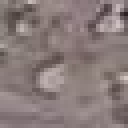

In [31]:
image_to_select = rand(1:size(train_X)[2])
a = reshape_image_array_reverse(train_X[:, [image_to_select]])
a2 = a[:,:,:,1]
a3 = permuteddimsview(a2, [3, 1, 2])
a3 = Array{Float32}(a3)
println("Ground truth ", train_Y[1, image_to_select])
println("Prediction ", Int(predicts[1, image_to_select]))
println("Filename ", df[image_to_select, 1])
colorview(RGB, a3)

# Training on GPU

In [65]:
# Make sure to import these before including the GPU file
using CuArrays, CUDAnative, CUDAdrv

In [73]:
include("../../NeuralNetworkGPU.jl")

predict (generic function with 2 methods)

In [67]:
# Copy inputs to GPU
train_X_cu = CuArray{Float32}(train_X)
train_Y_cu = CuArray{Float32}(train_Y)
test_X_cu = CuArray{Float32}(test_X)

3072×4000 CuArray{Float32,2,Nothing}:
 0.223529  0.313726  0.372549  0.439216  …  0.2       0.352941  0.486275
 0.207843  0.301961  0.447059  0.431373     0.207843  0.345098  0.564706
 0.384314  0.223529  0.466667  0.341176     0.184314  0.360784  0.478431
 0.313726  0.2       0.388235  0.392157     0.164706  0.360784  0.54902 
 0.258824  0.227451  0.403922  0.698039     0.172549  0.34902   0.533333
 0.294118  0.243137  0.564706  0.945098  …  0.164706  0.317647  0.592157
 0.294118  0.231373  0.639216  0.909804     0.160784  0.34902   0.411765
 0.227451  0.207843  0.552941  0.788235     0.196078  0.32549   0.368627
 0.188235  0.258824  0.45098   0.568627     0.2       0.372549  0.462745
 0.145098  0.227451  0.447059  0.360784     0.172549  0.384314  0.447059
 0.192157  0.203922  0.462745  0.364706  …  0.231373  0.337255  0.443137
 0.180392  0.211765  0.435294  0.603922     0.188235  0.435294  0.466667
 0.286275  0.278431  0.396078  0.784314     0.443137  0.364706  0.482353
 ⋮           

In [70]:
# Train (same as CPU, the differences are internal)
layer_dims = [3072, 10, 1]
parameters, activations = neural_network_dense(train_X_cu, train_Y_cu, layer_dims, 1000, 0.01)

Cost at iteration 100 is 0.5647224
Cost at iteration 200 is 0.5476341
Cost at iteration 300 is 0.52872497
Cost at iteration 400 is 0.5072823
Cost at iteration 500 is 0.48614806
Cost at iteration 600 is 0.46743584
Cost at iteration 700 is 0.4505398
Cost at iteration 800 is 0.43496487
Cost at iteration 900 is 0.4197568
Cost at iteration 1000 is 0.40447333


(Dict{String,CuArray{Float32,N,P} where P where N}("W2" => [0.95198 0.02848694 … -0.13759753 -0.49104062],"W1" => [0.030079698 0.020358711 … 0.036605056 0.014261343; -0.0007204305 0.041067842 … 0.008999812 -0.018836187; … ; 0.00020233051 0.030601583 … 0.011430751 -0.010953117; -0.014287941 -0.0026446225 … 0.023334943 -0.006680602],"b2" => [0.12941827],"b1" => [0.14255497; 0.0005024801; … ; -0.0018493138; 0.0]), (relu, sigmoid))

In [71]:
predicts, accuracy = predict(train_X_cu, train_Y_cu, parameters, activations)

Accuracy is 80.04%


([1.0 1.0 … 1.0 1.0], 0.8004)

In [76]:
parameters, activations = neural_network_dense(train_X_cu, train_Y_cu, layer_dims, 2000, 0.01,
    resume=true,
    parameters=parameters)

Cost at iteration 100 is 0.3495312
Cost at iteration 200 is 0.34602323
Cost at iteration 300 is 0.34349325
Cost at iteration 400 is 0.34028658
Cost at iteration 500 is 0.3377237
Cost at iteration 600 is 0.33544388
Cost at iteration 700 is 0.33455497
Cost at iteration 800 is 0.33253685
Cost at iteration 900 is 0.3293992
Cost at iteration 1000 is 0.3271491
Cost at iteration 1100 is 0.3267166
Cost at iteration 1200 is 0.3239965
Cost at iteration 1300 is 0.32165253
Cost at iteration 1400 is 0.31988832
Cost at iteration 1500 is 0.31849095
Cost at iteration 1600 is 0.31634304
Cost at iteration 1700 is 0.31523782
Cost at iteration 1800 is 0.31360775
Cost at iteration 1900 is 0.31181368
Cost at iteration 2000 is 0.31036097


(Dict{String,CuArray{Float32,N,P} where P where N}("W2" => [1.4653492 0.10109289 … -0.13764928 -0.49104062],"W1" => [0.048718162 0.03724996 … 0.031019641 0.016629651; -0.00049020536 0.041158874 … 0.008455669 -0.019125642; … ; 0.00022184718 0.030627375 … 0.011487914 -0.010937175; -0.014287941 -0.0026446225 … 0.023334943 -0.006680602],"b2" => [0.6715299],"b1" => [0.8871918; 0.01945028; … ; -0.0018106296; 0.0]), (relu, sigmoid))

In [77]:
predicts, accuracy = predict(train_X_cu, train_Y_cu, parameters, activations)

Accuracy is 87.08%


([1.0 1.0 … 0.0 1.0], 0.8708)